<h1 id="tocheading">Проект: Исследование Яндекс.Афиши</h1>
<div id="toc"></div>

## Цель проекта
Проанализировать данные использования Яндекс.Афиши пользователями и оптимизировать маркетинговые затраты. Рекомендации опираются на профиль активности пользователя, начало покупок в приложении, прибыль каждого клиента и окупаемость клиента. 

### План работы:
[ 1. Импортировать все нужные библиотеки и датасет. Изучить всю общую информацию о датасете.](#step1)

[ 2. Подготовить данные к анализу. Проверить на наличие пропусков. Объясннить логику исправления найденных ошибок.](#step2)


[ 3. Продуктовые метрики ](#step3)


[ 4. Метрики продаж](#step4)

[ 5. Траты на маркетинг и их окупаемость](#step5)

[ 6. Общий вывод](#step6)

## <a id="step1">1. Импорт нужных библиотек и датасетов. Изучить всю общую информацию о датасете.</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None


pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) 

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Как можем заметить, во всех табличках все столбцы имеют одинаковое количество строк. Некоторые столбцы, которые обозначают временные параметра имеют тип данных object, поэтому тип данных в этих столбцах следует изменить.

## <a id="step2">2. Подготовим данные к анализу.</a>

In [8]:
# приводим колонки к нижнему регистру
visits.columns = visits.columns.str.lower()

In [9]:
# задаем колонкам удобные названия
visits.columns = ['device','end_ts', 'source_id', 'start_ts', 'uid']

In [10]:
# приведём начало и конец сессии к типу datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [11]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# приведем названия столбцов к нижнему регистру, удобным названиям и типу datetime
orders.columns = orders.columns.str.lower()

In [13]:
orders.columns = ['order_date', 'revenue', 'uid']

In [14]:
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [15]:
# приведем данные столбца к типу datetime
costs['dt'] = pd.to_datetime(costs['dt'])

In [16]:
visits.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
costs.duplicated().sum()

0

Как можем заметить в наших рабочих таблицах отсутствуют дублирующиеся строки. Также мы привели все столбцы со временнем к типу данных datetime, что позволит нам совершать в проекте требуемые операции. 

## <a id="step3">3. Анализ продуктовых метрик и отчёт по ним.</a>

Создаём отдельные столбцы для различных промежутков времени, чтобы было можно сгруппировать по ним или посмотреть вариативность признака в этих промежутках.

In [19]:
# неделя сессии
visits['session_week'] = visits['start_ts'].dt.week

In [20]:
# месяц сессии
visits['session_month'] = visits['start_ts'].dt.month

In [21]:
# год сессии
visits['session_year'] = visits['start_ts'].dt.year

In [22]:
# день сессии
visits['session_date'] = visits['start_ts'].dt.date

In [23]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_week,session_month,session_year,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,51,12,2017,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,8,2,2018,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,26,7,2017,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,5,2018,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,52,12,2017,2017-12-27


In [24]:
# посчитаем метрики количества пользователей в сервисе
dau =  visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()

In [25]:
# sticky_wau = dau / wau. 
# Sticky factor для недельной аудитории 
sticky_wau = (dau / wau) * 100 

In [26]:
# sticky_wau = dau / wau. 
# Sticky factor для недельной аудитории 
sticky_mau = (dau / mau) * 100 

In [27]:
# количество пользователей в день
print("Количество пользователей в день:", int(dau))
print("Количество пользователей в неделю:", int(wau))
print("Количество пользователей в месяц:", int(mau))
print()
print("Sticky фактор недельной аудитории:", int(sticky_wau))
print("Sticky фактор месячной аудитории:", int(sticky_mau))

Количество пользователей в день: 907
Количество пользователей в неделю: 5716
Количество пользователей в месяц: 23228

Sticky фактор недельной аудитории: 15
Sticky фактор месячной аудитории: 3


### Длительность сессии и количество сессий 

#### Количество сессий в день на юзера

In [28]:
# сгруппируем по дням, чтобы вычислить количество сессий и пользователей
session_per_user_day = visits.groupby(['session_date']).agg({"uid":['count','nunique']})

In [29]:
# переименуем для ясности столбцы
session_per_user_day.columns = ['n_sessions','n_users']

In [30]:
# количество сессий на одного пользователя в день
session_per_user_day['sessions_per_user'] = session_per_user_day['n_sessions'] / session_per_user_day['n_users']

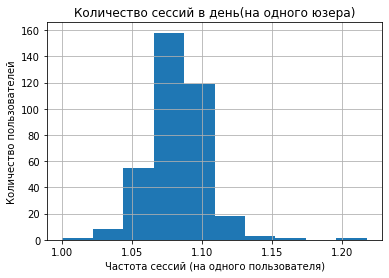

In [31]:
session_per_user_day['sessions_per_user'].hist()
plt.title('Количество сессий в день(на одного юзера)')
plt.xlabel('Частота сессий (на одного пользователя)')
plt.ylabel('Количество пользователей')
plt.show()

In [32]:
session_per_user_day.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.10
2017-06-02,658,608,1.08
2017-06-03,477,445,1.07
2017-06-04,510,476,1.07
2017-06-05,893,820,1.09


In [33]:
session_per_user_day['sessions_per_user'].describe()

count   364.00
mean      1.08
std       0.02
min       1.00
25%       1.07
50%       1.08
75%       1.09
max       1.22
Name: sessions_per_user, dtype: float64

В среднем пользователь совершает одну сессию в день. Это говорит о том, что либо юзерам достаточно одной сессии в день, либо после одной сессии они больше не хотят возвращаться к сервису в этот же день.  

#### Рассчитаем среднюю длительность сессии в секундах

In [34]:
# создаем столбец с длительностью в секундах для каждого пользователя
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds 

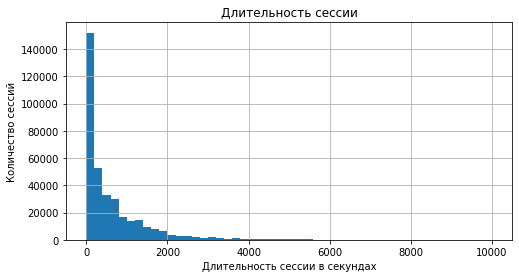

In [35]:
# посмотрим на распределение количества сессий различной длительности на гистограмме
visits['session_duration_sec'].hist(bins = 50, range = (0,10000), figsize = (8,4))
plt.title("Длительность сессии")
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.show()

На гистограмме хорошо видно, что большинство значений лежит ближе к нулю. 
В ситуации с настолько сильно сдвинутым распределением есть смысл вместо медианы или среднего использовать моду.

In [36]:
# average session length (als) - средняя длительность сессии 
# используем моду как наиболее часто встречаемое значение длительности сессий
asl = visits['session_duration_sec'].mode()

In [37]:
print(asl)

0    60
dtype: int64


Шестьдесят секунд - это достаточно короткий промежуток времени. Он говорит о том, что большинство пользователей либо быстро находят то, что им надо на сайте и покидает его. Либо пользователи не находят что им надо, поэтому быстро покидают страницу в поиске более подходящего сервиса.

#### Как часто люди возвращаются? Retention rate

In [38]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_week,session_month,session_year,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,51,12,2017,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,8,2,2018,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,26,7,2017,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,5,2018,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,52,12,2017,2017-12-27,0


In [39]:
# создадим серию с дотой первой сессии, сгруппированный по пользователям 
first_session = visits.groupby('uid')['session_date'].min()

In [40]:
first_session.name = 'first_session'

In [41]:
# объединим данные о первой сессии и общих сессиях
user_sessions = visits.join(first_session, on = 'uid')

In [42]:
# оставим только нужные для последующего анализа столбцы и уберем лишние
user_sessions = user_sessions[['device', 'source_id', 'uid', 'session_date', 'first_session']]

In [43]:
user_sessions.head()

,device,source_id,uid,session_date,first_session
0,touch,4,16879256277535980062,2017-12-20,2017-12-20
1,desktop,2,104060357244891740,2018-02-19,2018-02-19
2,touch,5,7459035603376831527,2017-07-01,2017-07-01
3,desktop,9,16174680259334210214,2018-05-20,2018-03-09
4,desktop,3,9969694820036681168,2017-12-27,2017-12-27


In [44]:
# создадим столбец, в котором заключен номер месяца первой сессии
user_sessions['first_month_activity'] = user_sessions['first_session'].astype('datetime64[M]')

Столбец first_month_activity будет выступать в качестве определяющего события когорты. Таким образом, мы сможем группировать вокруг этого события(первого месяца покупки) остальные характеристики наших наблюдений.

In [45]:
# создадим столбец, в котором заключен номер месяца сессии
user_sessions['month_activity'] = user_sessions['session_date'].astype('datetime64[M]')

Помимо начала жизненного цикла нам нужны будут временные промежутки по которым мы будем судить о изменении характеристик в течении времени. Месяца будут выступать в качестве временных ориентиров которые будут обозначать жизненный цикл и по которым мы будем измерять характеристики продукта во времени.

In [46]:
#  высчитываем столбец с жизненным циклом когорт
user_sessions['cohort_lifetime'] = user_sessions['month_activity'] - user_sessions['first_month_activity']

In [47]:
# приведем lifetime от значений дня к месяцам
user_sessions['cohort_lifetime'] = user_sessions['cohort_lifetime'] / np.timedelta64(1,'M')

In [48]:
# округлим до целых чисел и приведем к целочисленному типу 
user_sessions['cohort_lifetime'] = user_sessions['cohort_lifetime'].round()

In [49]:
user_sessions['cohort_lifetime']= user_sessions['cohort_lifetime'].astype('int')

In [50]:
user_sessions.sample(5)

,device,source_id,uid,session_date,first_session,first_month_activity,month_activity,cohort_lifetime
246968,desktop,2,15827319731686808417,2017-11-24,2017-09-19,2017-09-01,2017-11-01,2
266626,touch,9,3036956166375784426,2018-05-18,2018-03-08,2018-03-01,2018-05-01,2
252769,touch,5,15546167885784634366,2017-09-21,2017-09-21,2017-09-01,2017-09-01,0
353762,desktop,3,9837379647868440803,2017-10-12,2017-10-12,2017-10-01,2017-10-01,0
312180,desktop,3,7136717155826659180,2017-12-17,2017-12-17,2017-12-01,2017-12-01,0


In [51]:
# сгруппируем данные по когорте и lifetime
cohorts_sessions = user_sessions.groupby(['first_month_activity','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [52]:
cohorts_sessions.head(5)

,first_month_activity,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [53]:
# посчитаем изначальное количество пользователей в когорте в разные месяцы
initial_users_count = cohorts_sessions[cohorts_sessions['cohort_lifetime'] == 0][['first_month_activity','uid']]

In [54]:
initial_users_count = initial_users_count.rename(columns={'uid':'number_cohort_users'})

In [55]:
initial_users_count.sample(5)

,first_month_activity,number_cohort_users
63,2018-01-01,22624
68,2018-02-01,22197
75,2018-04-01,15709
77,2018-05-01,15273
12,2017-07-01,13140


In [56]:
# для подсчёта retention rate нам нужно посчитать и сравнить
# процент пользователей в последующих после начального месяцах lifetime когорты
# объединим изначальное количество пользователей и данные по когортам
cohorts = cohorts_sessions.merge(initial_users_count, on = 'first_month_activity')

In [57]:
cohorts.head(5)

,first_month_activity,cohort_lifetime,uid,number_cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [58]:
# считаем индекс удержания посредством соотнесения 
# количества пользователей в когорте  
# к изначальному количеству пользователей в когорте в ее нулевой lifetime
cohorts['retention'] = cohorts['uid'] / cohorts['number_cohort_users']

In [59]:
cohorts['pivot_month_activity'] = cohorts['first_month_activity'].dt.strftime('%Y-%m')

In [60]:
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 6 columns):
first_month_activity    78 non-null datetime64[ns]
cohort_lifetime         78 non-null int64
uid                     78 non-null int64
number_cohort_users     78 non-null int64
retention               78 non-null float64
pivot_month_activity    78 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 4.3+ KB


In [61]:
cohorts_retention_pivot = cohorts.pivot_table(index = 'pivot_month_activity', 
                                              columns = 'cohort_lifetime', 
                                              values = 'retention', 
                                              aggfunc = 'sum')

In [62]:
cohorts_retention_pivot.fillna("")

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
pivot_month_activity,,,,,,,,,,,,
2017-06,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,
2017-08,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,,
2017-09,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,,,
2017-10,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,,,,
2017-11,1.00,0.08,0.04,0.04,0.03,0.02,0.02,,,,,
2017-12,1.00,0.06,0.04,0.03,0.02,0.02,,,,,,
2018-01,1.00,0.06,0.04,0.02,0.02,,,,,,,
2018-02,1.00,0.06,0.03,0.02,,,,,,,,


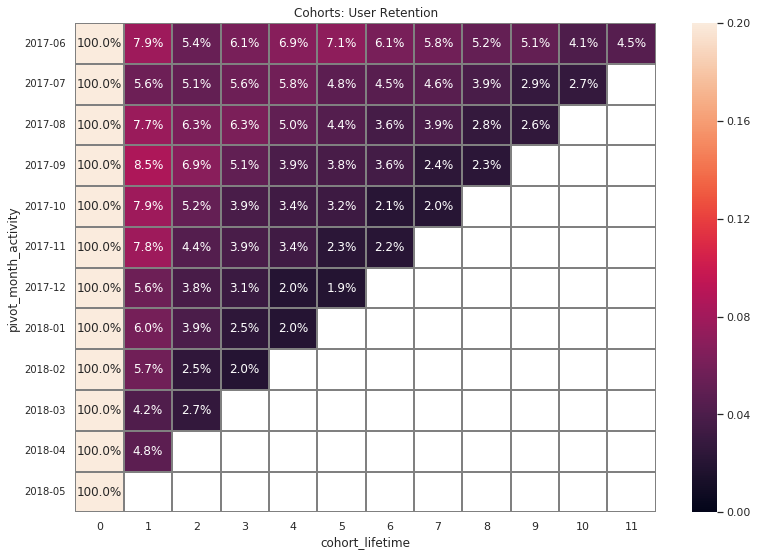

In [63]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
plt.yticks(rotation=1, fontsize="10", va="center")
sns.heatmap(cohorts_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmax= 0.2, vmin=0);


Как можем заметить индекс удержания во всех когортах продолжает падать весь жизненный цикл. Это говорит о том, что либо качество продукта по какой-либо причине не устраивает пользователей, либо мы изначально привлекли не лучшую целевую аудиторию, которой наш продукт не особенно нужен. 

#### Выводы по продуктовым метрикам
1. Профиль активности пользователя демонстрирует, что в среднем пользователь совершает одну сессию в день, которая длится 60 секунд. 
2. Это может свидетельствовать о том, что пользователи не очень удволетворены качеством услуг и достаточно быстро уходят с сервиса. 
3. То, что Retention rate  постоянно падает во время жизненног цикла и никогда не превышает 5-7%, даже в первый месяц ( не нулевой) lifetime свидетельствует о низком уровне удержания пользователя в приложении и частично поддерживает предположение о том, что многие пользователи не очень удволетворены качеством услуг и большинство быстро покидает сервис. 


## <a id="step4">4. Метрики продаж.</a>

### Когда люди начинают покупать

In [64]:
orders.head(2)

,order_date,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [65]:
# выделим первый заказ для последующего формирования когорты по нему
first_order_date = orders.groupby('uid')['order_date'].min()

In [66]:
first_order_date.name = 'first_order_date'

In [67]:
first_order_date.columns = ['uid','first_order_date']

In [68]:
# объединим изначальную таблицу и таблицу с первым заказом по id юзера
orders_updated = orders.merge(first_order_date, on = 'uid')

In [69]:
orders_updated.head(2)

,order_date,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00


In [70]:
session_updated = user_sessions[['uid','first_session']]

In [71]:
session_updated.head()

,uid,first_session
0,16879256277535980062,2017-12-20
1,104060357244891740,2018-02-19
2,7459035603376831527,2017-07-01
3,16174680259334210214,2018-03-09
4,9969694820036681168,2017-12-27


In [72]:
# объединим таблицу визитов и покупок, чтобы соотнести покупки и посещения сервиса
purchase_sessions = orders_updated.merge(session_updated, on = 'uid')

In [73]:
purchase_sessions.uid.duplicated().sum()

725284

In [74]:
# уберём дубликаты
purchase_sessions_upd = purchase_sessions.drop_duplicates(['uid'])

In [75]:
purchase_sessions_upd['first_session'] = pd.to_datetime(purchase_sessions_upd['first_session'])

In [76]:
# создадим столбец, где посчитаем среднее время от первой сессии до покупки
purchase_sessions_upd['purchase_period'] = purchase_sessions_upd['first_order_date'] - purchase_sessions_upd['first_session']

In [77]:
purchase_sessions_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 0 to 761806
Data columns (total 6 columns):
order_date          36523 non-null datetime64[ns]
revenue             36523 non-null float64
uid                 36523 non-null uint64
first_order_date    36523 non-null datetime64[ns]
first_session       36523 non-null datetime64[ns]
purchase_period     36523 non-null timedelta64[ns]
dtypes: datetime64[ns](3), float64(1), timedelta64[ns](1), uint64(1)
memory usage: 2.0 MB


In [78]:
purchase_sessions_upd['purchase_period'] = purchase_sessions_upd['purchase_period'] / np.timedelta64(1,'D')

In [79]:
purchase_sessions_upd['purchase_period'] = purchase_sessions_upd['purchase_period'].round().astype('int') 

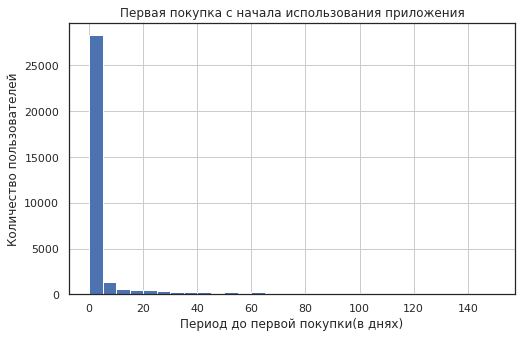

In [80]:
purchase_sessions_upd['purchase_period'].hist(bins = 30, figsize = (8,5), range = (0,150))
plt.title("Первая покупка с начала использования приложения")
plt.xlabel("Период до первой покупки(в днях)")
plt.ylabel("Количество пользователей")
plt.show()

Как можем заметить из гистограммы данные сдвинуты в сторону малых значений. Наибольшее количество пользователей (около 20 000) покупает на следующий день после начала использования сервиса, либо в самые первые дни.

In [81]:
# 50 000 покупок совершено в первый день использования сервиса, а еще по 5 тысяч в 1 и 2 дни
purchase_sessions_upd['purchase_period'].value_counts().head(10)

1    19923
0     5935
2     1336
3      612
4      464
5      335
6      302
7      261
8      226
9      190
Name: purchase_period, dtype: int64

In [82]:
purchase_sessions_upd['purchase_period'].describe()

count   36,523.00
mean        17.64
std         47.07
min          0.00
25%          1.00
50%          1.00
75%          3.00
max        364.00
Name: purchase_period, dtype: float64

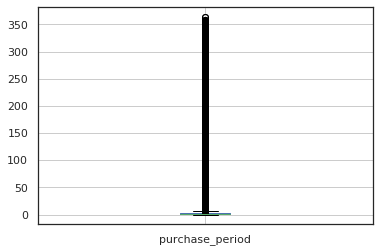

In [83]:
purchase_sessions_upd.boxplot(column = 'purchase_period')
plt.show()

Среднее значение составляет примерно 16 дней с начала покупки. Интерквартильный размах находится в диапазоне от 0 до 3 дней. Учитывая, что мин. значение также составляет 0, 75% всех покупок приходятся на первый несколько дней.  Несмотря на то, что множество пользователей покупает в первые дни использования приложения, мы имеем среднее 17, и как видно на боксплоте, присутствует выбросы, которые сдвигают среднее и станд.отклонение. 

### Сколько раз покупают за период 

Для того, чтобы следить как изменялся признак с течением времени, в данном случае покупки в сервисе, нам нужно разбить время на временные промежутки по которым мы будем производить измерения - день, неделя, месяц.

In [84]:
# создадим столбы с месяцем первой покупки и месяцем совершаемой покупки 
orders_updated['first_order_month'] = orders_updated['first_order_date'].astype('datetime64[M]')

In [85]:
orders_updated['order_month'] = orders_updated['order_date'].astype('datetime64[M]')

In [86]:
orders_updated['order_week'] = orders_updated['order_date'].astype('datetime64[W]')

In [87]:
orders_updated['order_date_day'] = orders_updated['order_date'].dt.date

In [88]:
orders_updated.head(10)

,order_date,revenue,uid,first_order_date,first_order_month,order_month,order_week,order_date_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,2017-06-01,2017-06-05
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,2017-06-01,2017-06-02


Посчитаем динамику количества покупок по месяцам и в среднем. Стоит уточнить, что мы считаем не количество уникальных пользователей, а количество покупок, т.к один пользователь мог совершать покупку не единожды.

In [89]:
orders_count_month = orders_updated.groupby('order_month').agg({"uid":'count'}).reset_index()

In [90]:
orders_count_month

,order_month,uid
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


Как можем заметить наибольшее количество покупок по времени приходится на октябрь-март, когда количество покупок растет до более пяти тысяч покупок в месяц.

In [91]:
print("В среднем в месяц пользователи совершают", orders_count_month.uid.mean().round().astype('int'),"покупок")

В среднем в месяц пользователи совершают 3878 покупок


Посчитаем сколько раз в среднем покупали в день и в неделю


In [92]:
orders_count_day = orders_updated.groupby('order_date_day').agg({"uid":'count'}).reset_index()

In [93]:
print("В среднем в день пользователи совершают", orders_count_day.uid.mean().round().astype('int'),"покупок")

В среднем в день пользователи совершают 139 покупок


In [94]:
orders_count_week = orders_updated.groupby('order_week').agg({"uid":'count'}).reset_index()

In [95]:
print("В среднем в неделю пользователи совершают", orders_count_week.uid.mean().round().astype('int'),"покупок")

В среднем в неделю пользователи совершают 951 покупок


### Динамика изменения абсолютных показателей по периодам

Выведем количество уникальных покупателей и количество прибылиь по месяцам и по неделям в динамике.

In [96]:
# сгруппируем данные по столбцу первой покупки 

orders_updated_users_month = orders_updated.pivot_table(index = 'first_order_month', columns = 'order_month', values = 'uid', aggfunc = 'nunique')

In [97]:
# посмотрим на показатели помесячного количества уникальных покупателей разных когорт
orders_updated_users_month.fillna("")

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,"2,023.00",61.00,50.00,54.00,88.00,67.00,62.00,47.00,58.00,45.00,45.00,53.00,
2017-07-01,,"1,923.00",52.00,57.00,64.00,49.00,38.00,36.00,39.00,42.00,22.00,26.00,
2017-08-01,,,"1,370.00",58.00,53.00,44.00,40.00,32.00,30.00,44.00,19.00,31.00,
2017-09-01,,,,"2,581.00",130.00,100.00,74.00,52.00,64.00,66.00,37.00,43.00,
2017-10-01,,,,,"4,340.00",206.00,123.00,92.00,93.00,72.00,56.00,67.00,
2017-11-01,,,,,,"4,081.00",222.00,120.00,106.00,81.00,48.00,62.00,
2017-12-01,,,,,,,"4,383.00",146.00,103.00,97.00,50.00,63.00,
2018-01-01,,,,,,,,"3,373.00",114.00,83.00,43.00,45.00,
2018-02-01,,,,,,,,,"3,651.00",118.00,58.00,39.00,


1. Как можем заметить после первого месяца количество покупателей в когорте всегда значительно падает.
2. Потом может колебаться: чуть подрастёт, а потом опять упадет. 

In [98]:
orders_updated_count_month = orders_updated.pivot_table(index = 'first_order_month', \
                                                  columns = 'order_month', values = 'uid', aggfunc = 'count')

In [99]:
# количество заказов в каждой когорте на каждый месяц  
orders_updated_count_month.fillna("")

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,"2,354.00",177.00,174.00,226.00,292.00,218.00,276.00,174.00,212.00,153.00,96.00,86.00,
2017-07-01,,"2,186.00",100.00,120.00,104.00,72.00,82.00,61.00,50.00,58.00,24.00,53.00,
2017-08-01,,,"1,533.00",108.00,100.00,81.00,85.00,62.00,49.00,78.00,46.00,46.00,
2017-09-01,,,,"2,933.00",219.00,161.00,164.00,67.00,109.00,108.00,56.00,61.00,
2017-10-01,,,,,"4,964.00",314.00,162.00,122.00,129.00,103.00,86.00,125.00,
2017-11-01,,,,,,"4,813.00",397.00,182.00,211.00,136.00,59.00,102.00,
2017-12-01,,,,,,,"5,052.00",270.00,202.00,179.00,86.00,105.00,
2018-01-01,,,,,,,,"3,783.00",224.00,159.00,64.00,78.00,
2018-02-01,,,,,,,,,"4,095.00",222.00,83.00,70.00,


In [100]:
orders_updated_week = orders_updated.pivot_table(index = 'first_order_month', \
                                                   columns = 'order_week', values = 'uid', aggfunc = 'nunique')

In [101]:
# количество покупателей разных когорт на разных неделях жизненного цикла когорты
orders_updated_week.head(10).fillna('0')

order_week,2017-06-01,2017-06-08,2017-06-15,2017-06-22,2017-06-29,2017-07-06,2017-07-13,2017-07-20,2017-07-27,2017-08-03,2017-08-10,2017-08-17,2017-08-24,2017-08-31,2017-09-07,2017-09-14,2017-09-21,2017-09-28,2017-10-05,2017-10-12,2017-10-19,2017-10-26,2017-11-02,2017-11-09,2017-11-16,2017-11-23,2017-11-30,2017-12-07,2017-12-14,2017-12-21,2017-12-28,2018-01-04,2018-01-11,2018-01-18,2018-01-25,2018-02-01,2018-02-08,2018-02-15,2018-02-22,2018-03-01,2018-03-08,2018-03-15,2018-03-22,2018-03-29,2018-04-05,2018-04-12,2018-04-19,2018-04-26,2018-05-03,2018-05-10,2018-05-17,2018-05-24,2018-05-31
first_order_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-01,774.00,478.00,310.00,396.00,147.00,22.00,28.00,13.00,12.00,12.00,16.00,21.00,23.00,18.00,21.00,20.00,23.00,27.00,39.00,23.00,27.00,27.00,20.00,23.00,18.00,33.00,22.00,30.00,23.00,20.00,23.00,13.00,14.00,21.00,18.00,17.00,19.00,27.00,24.00,21.00,14.00,21.00,18.00,11.00,12.00,21.00,19.00,6.00,9.00,10.00,19.00,26.00,6.00
2017-07-01,0,0,0,0,269.00,423.00,705.00,383.00,205.00,19.00,11.00,14.00,16.00,21.00,13.00,14.00,16.00,25.00,19.00,18.00,12.00,16.00,8.00,13.00,10.00,22.00,11.00,8.00,13.00,11.00,14.00,8.00,6.00,11.00,11.00,9.00,19.00,8.00,9.00,9.00,10.00,13.00,11.00,2.00,5.00,5.00,4.00,8.00,4.00,9.00,8.00,8.00,5.00
2017-08-01,0,0,0,0,0,0,0,0,68.00,233.00,282.00,343.00,403.00,98.00,18.00,15.00,11.00,13.00,14.00,15.00,16.00,9.00,15.00,17.00,14.00,8.00,14.00,9.00,11.00,10.00,11.00,9.00,9.00,11.00,10.00,8.00,10.00,8.00,7.00,16.00,7.00,8.00,16.00,7.00,4.00,5.00,10.00,8.00,10.00,9.00,7.00,7.00,2.00
2017-09-01,0,0,0,0,0,0,0,0,0,0,0,0,0,396.00,520.00,595.00,736.00,451.00,42.00,33.00,28.00,22.00,31.00,18.00,22.00,43.00,26.00,27.00,18.00,16.00,17.00,10.00,7.00,17.00,18.00,18.00,21.00,17.00,22.00,27.00,11.00,13.00,23.00,10.00,9.00,12.00,9.00,7.00,4.00,13.00,15.00,15.00,4.00
2017-10-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,651.00,"1,243.00",962.00,916.00,779.00,66.00,51.00,41.00,62.00,32.00,31.00,34.00,38.00,24.00,25.00,31.00,16.00,22.00,30.00,29.00,29.00,20.00,27.00,13.00,18.00,25.00,8.00,15.00,18.00,14.00,15.00,9.00,13.00,23.00,26.00,7.00
2017-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115.00,747.00,761.00,945.00,"1,528.00",237.00,68.00,38.00,35.00,34.00,23.00,42.00,30.00,39.00,31.00,31.00,38.00,27.00,23.00,16.00,18.00,34.00,7.00,16.00,14.00,12.00,11.00,9.00,13.00,27.00,13.00,4.00
2017-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,822.00,"1,056.00",871.00,"1,074.00",738.00,42.00,40.00,27.00,39.00,35.00,33.00,26.00,30.00,30.00,24.00,34.00,26.00,5.00,16.00,16.00,21.00,8.00,14.00,16.00,20.00,17.00,7.00
2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,357.00,676.00,701.00,792.00,950.00,55.00,35.00,28.00,21.00,28.00,16.00,24.00,29.00,7.00,9.00,16.00,15.00,10.00,11.00,14.00,11.00,12.00,6.00
2018-02-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,909.00,"1,047.00",980.00,830.00,47.00,35.00,28.00,33.00,8.00,15.00,14.00,20.00,14.00,13.00,6.00,16.00,9.00,4.00


In [102]:
# количество заказов в разных когортах на каждую неделю жизненного цикла
orders_updated_count_week = orders_updated.pivot_table(index = 'first_order_month', \
                                                  columns = 'order_week', values = 'uid', aggfunc = 'count')

In [103]:
orders_updated_count_week.fillna("")

order_week,2017-06-01,2017-06-08,2017-06-15,2017-06-22,2017-06-29,2017-07-06,2017-07-13,2017-07-20,2017-07-27,2017-08-03,2017-08-10,2017-08-17,2017-08-24,2017-08-31,2017-09-07,2017-09-14,2017-09-21,2017-09-28,2017-10-05,2017-10-12,2017-10-19,2017-10-26,2017-11-02,2017-11-09,2017-11-16,2017-11-23,2017-11-30,2017-12-07,2017-12-14,2017-12-21,2017-12-28,2018-01-04,2018-01-11,2018-01-18,2018-01-25,2018-02-01,2018-02-08,2018-02-15,2018-02-22,2018-03-01,2018-03-08,2018-03-15,2018-03-22,2018-03-29,2018-04-05,2018-04-12,2018-04-19,2018-04-26,2018-05-03,2018-05-10,2018-05-17,2018-05-24,2018-05-31
first_order_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-01,896.00,525.00,341.00,441.00,177.00,51.00,61.00,22.00,27.00,40.00,25.00,50.00,40.00,50.00,50.00,53.00,58.00,60.00,91.00,60.00,51.00,62.00,39.00,34.00,46.00,84.00,65.00,72.00,54.00,69.00,38.00,42.00,29.00,38.00,50.00,54.00,33.00,65.00,60.00,49.00,22.00,50.00,29.00,15.00,18.00,31.00,26.00,11.00,12.00,15.00,22.00,29.00,6.00
2017-07-01,,,,,284.00,466.00,765.00,438.00,240.00,37.00,11.00,23.00,19.00,25.00,26.00,32.00,25.00,32.00,27.00,26.00,17.00,19.00,9.00,15.00,10.00,32.00,19.00,21.00,13.00,20.00,20.00,12.00,15.00,12.00,15.00,9.00,23.00,9.00,9.00,10.00,11.00,18.00,18.00,2.00,5.00,5.00,5.00,8.00,4.00,16.00,13.00,14.00,6.00
2017-08-01,,,,,,,,,71.00,242.00,311.00,376.00,442.00,122.00,20.00,23.00,19.00,26.00,21.00,26.00,24.00,20.00,20.00,27.00,19.00,9.00,22.00,16.00,14.00,21.00,20.00,9.00,15.00,20.00,14.00,14.00,10.00,11.00,14.00,24.00,9.00,14.00,28.00,7.00,5.00,9.00,21.00,10.00,11.00,15.00,8.00,7.00,2.00
2017-09-01,,,,,,,,,,,,,,434.00,560.00,641.00,834.00,498.00,64.00,60.00,40.00,24.00,35.00,23.00,24.00,70.00,44.00,45.00,36.00,30.00,21.00,11.00,9.00,17.00,24.00,28.00,36.00,19.00,26.00,38.00,14.00,21.00,33.00,12.00,12.00,15.00,10.00,9.00,6.00,16.00,17.00,17.00,5.00
2017-10-01,,,,,,,,,,,,,,,,,,705.00,"1,372.00","1,042.00",987.00,873.00,79.00,68.00,56.00,85.00,39.00,42.00,38.00,41.00,27.00,28.00,34.00,19.00,27.00,34.00,33.00,39.00,23.00,33.00,21.00,19.00,28.00,8.00,22.00,22.00,23.00,17.00,11.00,16.00,47.00,38.00,9.00
2017-11-01,,,,,,,,,,,,,,,,,,,,,,121.00,816.00,826.00,"1,029.00","1,840.00",324.00,103.00,58.00,60.00,46.00,27.00,50.00,39.00,53.00,51.00,46.00,64.00,50.00,34.00,19.00,33.00,47.00,7.00,16.00,18.00,12.00,12.00,11.00,15.00,43.00,26.00,4.00
2017-12-01,,,,,,,,,,,,,,,,,,,,,,,,,,,917.00,"1,180.00",969.00,"1,196.00",829.00,63.00,60.00,51.00,57.00,56.00,48.00,46.00,52.00,49.00,39.00,58.00,32.00,6.00,24.00,20.00,27.00,11.00,19.00,24.00,30.00,23.00,8.00
2018-01-01,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,393.00,726.00,760.00,868.00,"1,036.00",81.00,52.00,46.00,45.00,40.00,23.00,34.00,57.00,8.00,9.00,22.00,18.00,15.00,13.00,20.00,20.00,16.00,6.00
2018-02-01,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,980.00,"1,148.00","1,071.00",896.00,68.00,50.00,49.00,53.00,15.00,19.00,16.00,23.00,14.00,16.00,7.00,30.00,11.00,4.00


### Средний чек

In [104]:
orders_updated.revenue.mean()

4.999646930477041

СРЕДНИЙ ЧЕК на одного покупателя составляет 4.99 у.е.

In [105]:
orders_updated.sample(2)

,order_date,revenue,uid,first_order_date,first_order_month,order_month,order_week,order_date_day
24608,2017-12-01 14:18:00,4.58,9156947215999310287,2017-11-28 15:11:00,2017-11-01,2017-12-01,2017-11-30,2017-12-01
19764,2017-11-03 12:03:00,9.17,484275825079452766,2017-11-03 12:03:00,2017-11-01,2017-11-01,2017-11-02,2017-11-03


In [106]:
# посчитаем средний чек на пользователя
avg_check = orders_updated.groupby('order_date').agg({'revenue':'sum','uid':'count'})

In [107]:
# для этого разделим прибыль от всех пользователей на общее количество транзакций всех пользователей
avg_check['avg_check'] = avg_check['revenue'] / avg_check['uid']

In [108]:
avg_check['avg_check'].mean()

4.99321061367079

СРЕДНИЙ ЧЕК равен 4.99 у.е

In [109]:
# сгруппируем доходы с количеством уникальных пользователей по когортам
orders_groupped_cohorts = orders_updated.groupby(['first_order_month','order_month']). \
    agg({'order_date': 'nunique', 'revenue':'sum'})

In [110]:
orders_groupped_cohorts.head()

order_date  revenue
first_order_month order_month                     
2017-06-01        2017-06-01         2245 9,557.49
                  2017-07-01          176   981.82
                  2017-08-01          174   885.34
                  2017-09-01          223 1,931.30
                  2017-10-01          292 2,068.58

In [111]:
# найдем ARPPU посредством деления дохода на количество покупателей в когорте
orders_groupped_cohorts['revenue_per_user'] = orders_groupped_cohorts['revenue'] / orders_groupped_cohorts['order_date']

А вот столько в среднем принёс каждый платящий пользователь в месяц

In [112]:
orders_groupped_cohorts['revenue_per_user'].mean()

7.710404515275734

In [113]:
orders_groupped_cohorts.pivot_table(index = 'first_order_month',
                                   values = 'revenue_per_user',
                                   columns = 'order_month',
                                   aggfunc = 'mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.26,5.58,5.09,8.66,7.08,6.86,6.99,6.76,5.28,8.06,12.04,6.04,nan
2017-07-01,nan,5.57,6.45,9.99,6.70,4.72,3.66,3.85,5.57,5.35,11.79,5.65,nan
2017-08-01,nan,nan,4.88,6.04,6.28,6.70,8.06,6.27,5.89,7.11,8.70,5.60,nan
2017-09-01,nan,nan,nan,5.23,13.17,8.40,62.57,15.43,15.32,16.77,11.21,7.79,nan
2017-10-01,nan,nan,nan,nan,4.79,7.43,5.13,5.59,5.10,5.07,4.28,4.01,nan
2017-11-01,nan,nan,nan,nan,nan,4.91,4.18,4.52,6.31,4.44,3.73,4.60,nan
2017-12-01,nan,nan,nan,nan,nan,nan,4.47,4.24,20.07,26.08,15.95,14.11,nan
2018-01-01,nan,nan,nan,nan,nan,nan,nan,3.93,4.48,6.45,7.52,2.71,nan
2018-02-01,nan,nan,nan,nan,nan,nan,nan,nan,4.03,4.60,3.45,3.87,nan


In [114]:
orders_groupped_cohorts = orders_groupped_cohorts.reset_index()

In [115]:
# посмотрим как менялся ARPPU во время жизненного цикла различных когорт
# выделим lifetime по месяцам жизненного цикла когорты
orders_groupped_cohorts['cohort_lifetime'] = orders_groupped_cohorts['order_month'] - orders_groupped_cohorts['first_order_month']

In [116]:
# чтобы периодами жизненного цикла являлись не дни, а месяцы, поделим все значения на месяц
orders_groupped_cohorts['cohort_lifetime'] = orders_groupped_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

In [117]:
# округлим значения до целых
orders_groupped_cohorts['cohort_lifetime'] = orders_groupped_cohorts['cohort_lifetime'].round().astype('int')

In [118]:
# оставим в значении когорты только год и месяц
#orders_groupped_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')
orders_groupped_cohorts['first_order_month'] = orders_groupped_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [119]:
revenue_per_user_pivot = orders_groupped_cohorts.pivot_table(index = 'first_order_month',
                                                            values = 'revenue_per_user',
                                                            columns = 'cohort_lifetime',
                                                            aggfunc = 'mean')

In [120]:
revenue_per_user_pivot.fillna("")

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.26,5.58,5.09,8.66,7.08,6.86,6.99,6.76,5.28,8.06,12.04,6.04
2017-07,5.57,6.45,9.99,6.70,4.72,3.66,3.85,5.57,5.35,11.79,5.65,
2017-08,4.88,6.04,6.28,6.70,8.06,6.27,5.89,7.11,8.70,5.60,,
2017-09,5.23,13.17,8.40,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10,4.79,7.43,5.13,5.59,5.10,5.07,4.28,4.01,,,,
2017-11,4.91,4.18,4.52,6.31,4.44,3.73,4.60,,,,,
2017-12,4.47,4.24,20.07,26.08,15.95,14.11,,,,,,
2018-01,3.93,4.48,6.45,7.52,2.71,,,,,,,
2018-02,4.03,4.60,3.45,3.87,,,,,,,,


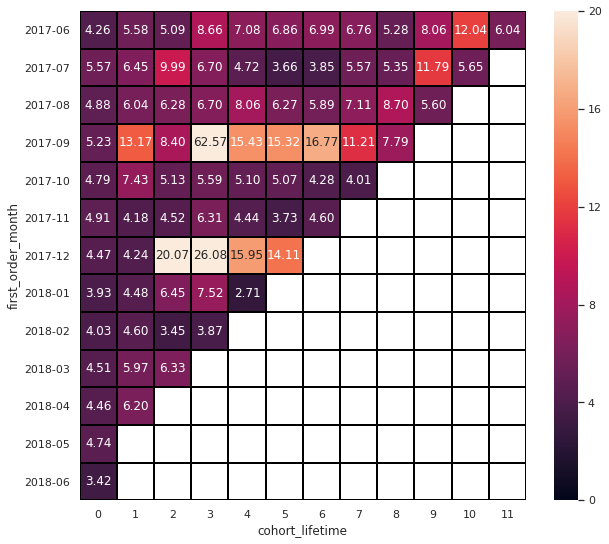

In [121]:
# визуализируем нашу табличку со ARPPU по когортам в lifetime
fig, ax = plt.subplots(figsize=(10,9))   
sns.heatmap(revenue_per_user_pivot, annot = True, fmt = '.2f', linewidth = 1, linecolor = 'black', vmax = 20, vmin = 0)
plt.show()

In [122]:
# посмотрим какие когорты принесли больше всего прибыли
revenue_per_user_pivot.cumsum(axis =1).fillna("")

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.26,9.84,14.92,23.58,30.67,37.53,44.52,51.28,56.56,64.62,76.66,82.70
2017-07,5.57,12.01,22.01,28.71,33.43,37.09,40.94,46.51,51.85,63.64,69.29,
2017-08,4.88,10.92,17.21,23.91,31.96,38.23,44.12,51.23,59.94,65.53,,
2017-09,5.23,18.40,26.80,89.37,104.80,120.13,136.89,148.10,155.89,,,
2017-10,4.79,12.22,17.35,22.94,28.04,33.11,37.39,41.40,,,,
2017-11,4.91,9.09,13.61,19.93,24.37,28.10,32.69,,,,,
2017-12,4.47,8.72,28.79,54.87,70.82,84.93,,,,,,
2018-01,3.93,8.41,14.87,22.39,25.10,,,,,,,
2018-02,4.03,8.62,12.08,15.94,,,,,,,,


1. СРЕДНИЙ ЧЕК на пользователя составляет 4.99 у.е. 
2. Наиболее прибыльными являются когорты июня,сентября и декабря 2017 года. 

#### Lifetime value (LTV). Сколько денег приносят пользователи

In [123]:
# посчитаем количество новых покупателей за каждый месяце, т.е размеры когорт
cohort_sizes = orders_updated.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()

In [124]:
cohort_sizes.columns = ['first_order_month','n_buyers']

In [125]:
orders_updated.sample(5)

,order_date,revenue,uid,first_order_date,first_order_month,order_month,order_week,order_date_day
38474,2018-02-19 06:38:00,3.67,14694711543653468306,2018-02-19 06:38:00,2018-02-01,2018-02-01,2018-02-15,2018-02-19
5470,2017-07-11 21:28:00,4.89,8505689801086874553,2017-07-11 21:28:00,2017-07-01,2017-07-01,2017-07-06,2017-07-11
24711,2018-02-03 14:29:00,7.09,6948781160947906362,2017-11-28 17:54:00,2017-11-01,2018-02-01,2018-02-01,2018-02-03
39137,2018-02-22 13:43:00,2.32,18222325164611704638,2018-02-22 13:43:00,2018-02-01,2018-02-01,2018-02-22,2018-02-22
45310,2018-04-12 09:06:00,6.11,4153465244730162096,2018-04-12 09:06:00,2018-04-01,2018-04-01,2018-04-12,2018-04-12


In [126]:
# каждая строка отображает какую прибыль принесла каждая когорта в каждый отдельный месяц
cohorts = orders_updated.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()

In [127]:
# объединим количество людей в когортах и количество прибыли в когортах  
# по первому месяцу покупки, т.е по когорте как таковой
cohorts_new = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')

In [128]:
# создадим "возрастные" отметки вдоль которых будут значения прибыли когорты
cohorts_new['age'] = (cohorts_new['order_month'] - cohorts_new['first_order_month']) / np.timedelta64(1, 'M')

In [129]:
cohorts_new['age'] = cohorts_new['age'].round().astype('int')

In [130]:
# рассчитаем ltv посредством деления дохода каждого пользователя на их количество
cohorts_new['ltv'] = cohorts_new['revenue'] / cohorts_new['n_buyers']

In [131]:
cohorts_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,"9,557.49",0,4.72
1,2017-06-01,2023,2017-07-01,981.82,1,0.49
2,2017-06-01,2023,2017-08-01,885.34,2,0.44
3,2017-06-01,2023,2017-09-01,"1,931.30",3,0.95
4,2017-06-01,2023,2017-10-01,"2,068.58",4,1.02


In [132]:
ltv_pivot = cohorts_new.pivot_table(index = 'first_order_month',
                        columns = 'age',
                        values = 'ltv',
                        aggfunc = 'mean').round(decimals = 2)

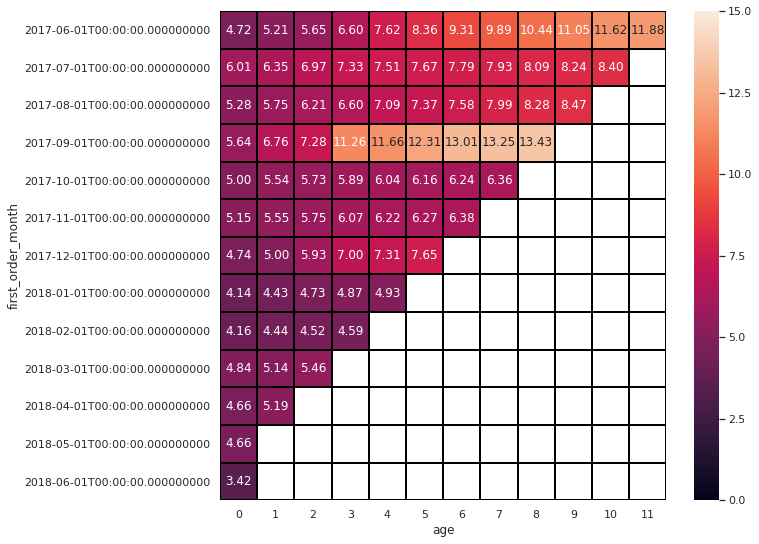

In [133]:
# визуализируем нашу табличку c ltv каждого пользователя когорты в рамках её жизненного цикла
fig, ax = plt.subplots(figsize=(10,9))   
sns.heatmap(ltv_pivot.cumsum(axis =1), annot = True, fmt = '.2f', linewidth = 1, linecolor = 'black',vmax= 15, vmin=0)

plt.show()

In [134]:
# т.к ltv кумулятивная метрика, посмотрим на изменения каждой когорты
ltv_pivot.cumsum(axis =1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,nan
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,nan,nan
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,nan,nan,nan
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,nan,nan,nan,nan
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,nan,nan,nan,nan,nan
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,nan,nan,nan,nan,nan,nan
2018-01-01,4.14,4.43,4.73,4.87,4.93,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.16,4.44,4.52,4.59,nan,nan,nan,nan,nan,nan,nan,nan


In [135]:
# выделим когорты, которые имели как минимум 6 месяцев lifetime
ltv_selected = ltv_pivot.iloc[0:7,0:6]

In [136]:
# посмотрим на ltv как аккумулятивную метрику
ltv_selected.cumsum(axis = 1)

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65


Июньская и сентябрьские когорты имели самые высокий ltv за шесть месяцев

In [137]:
ltv_selected.cumsum(axis = 1).mean(axis =0)

age
0   5.22
1   5.74
2   6.22
3   7.25
4   7.64
5   7.97
dtype: float64

### Вывод по разделу продажи



1. НАЧАЛО ПОКУПОК. Многие пользователи сервиса (более 20 тысяч) начинают покупать в первые три дня использования сервиса, хотя в среднем это показатель равен 17 из-за выбросов в больших значениях.
2. КОЛИЧЕСТВО ПОКУПОК ЗА ПЕРИОД. В месяц - 3878, в неделю - 951, 139 - в день.
3. СРЕДНИЙ ЧЕК на одного пользователя - 4,99 у.е 
- Наиболее прибыльными являются когорты июня,сентября и декабря 2017 года соответственно в сумме принёсшие 82, 155 и 84 у.е. 
4. Июньские и сентябрьские когорты 2017 имели самые высокие показатели ltv - 11,88 и 13.45 соответственно.
5. Ltv последовательно растёт от каждого месяца жизненного цикла к последующему, что является позитивным знаком для сервиса. Осталось соотнести ltv с расходами на привлечение пользователей по разным каналам.  

## <a id="step5">5. Маркетинговые вложения и их окупаемость.</a>

### Общие траты на источники маркетинга

In [138]:
costs.head(2)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


In [139]:
costs_sources = costs.groupby('source_id')['costs'].sum()

In [140]:
costs_sources.name = 'cost_sources'

In [141]:
costs_sources.sort_values(ascending = False)

source_id
3    141,321.63
4     61,073.60
5     51,757.10
2     42,806.04
1     20,833.27
10     5,822.49
9      5,517.49
Name: cost_sources, dtype: float64

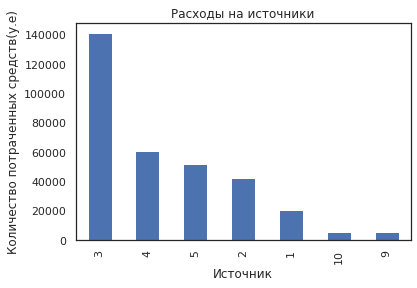

In [142]:
costs_sources.sort_values(ascending = False).plot(kind = 'bar')
plt.title('Расходы на источники')
plt.xlabel("Источник")
plt.ylabel("Количество потраченных средств(у.е)")
plt.show()

Как видим, с большим отрывом идёт рекламный источник №3. За ним идут чётвертый, пятый и второй. Меньше всего тратят на 10 и 9 источники.

Теперь посмотрим как различные рекламные источники используются во времени

In [143]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [144]:
costs_month = costs.groupby('month')['costs'].sum().reset_index()

In [145]:
costs_month.columns = ['month', 'costs_month']

In [146]:
costs_month['month'] = pd.to_datetime(costs_month['month'])

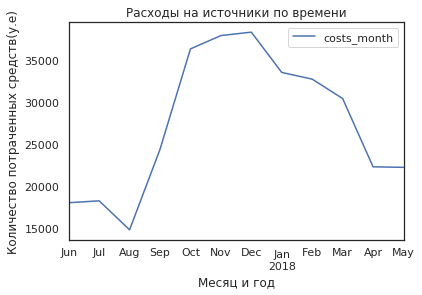

In [147]:

costs_month.plot.line(x='month', y='costs_month') 
plt.title('Расходы на источники по времени')
plt.xlabel("Месяц и год")
plt.ylabel("Количество потраченных средств(у.е)")
plt.show()

Как можем заметить наибольший расходы были с октября 2017 по февраль 2018

### Сколько стоило привлечение одного покупателя 

Для нахождения средней цены привлечения по источнику нам нужно получить количество покупателей в день и соотнести его с количеством средств потраченных в день на конкретный источник привлечения. 

Сгруппируем таблички с первым визитом пользователя на сайт, первой покупкой и источником привлечения, который привел покупателя на сайт.

In [148]:
# айдишники с датой первого визита
visits_first_entry = visits.groupby('uid')['session_date'].min().reset_index()

In [149]:
visits_first_entry.columns = ['uid','first_session_date']

In [150]:
# объединим первые визиты с полной табличкой визитов, из которой мы вытянем источник привлечения 
visits_groupped = pd.merge(visits_first_entry, visits[['uid', 'source_id','device']], on ='uid')

In [151]:
# выделим только первые визиты c айдишниками юзеров
visits_source  = visits_groupped.groupby(['uid','first_session_date']).first().reset_index() 

In [152]:
visits_source['first_vis_month'] = visits_source['first_session_date'].astype('datetime64[M]')

Объединим табличку заказов с визитами

In [153]:
# выделим только покупающих первый раз пользователей
# их последующие покупки нас не интересуют
orders_groupped = orders.groupby('uid')['order_date'].min().reset_index()

In [154]:
orders_groupped.columns = ['uid','first_order_date']

In [155]:
orders_new = orders_groupped.merge(orders, right_on =['order_date','uid'], left_on = ['first_order_date', 'uid'])

In [156]:
orders_groupped['first_month_order'] = orders_groupped['first_order_date'].astype('datetime64[M]')

In [157]:
# объединим таблички с покупками и первым визитом  
orders_visits = orders_new.merge(visits_source, on = 'uid')

In [158]:
orders_visits.head(2)

,uid,first_order_date,order_date,revenue,first_session_date,source_id,device,first_vis_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55,2017-09-18,2,desktop,2017-09-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2017-06-03,10,touch,2017-06-01


In [159]:
orders_visits['first_session_date'] = pd.to_datetime(orders_visits['first_session_date'])

In [160]:
orders_vis_groupped = orders_visits.groupby(['first_vis_month','source_id']).agg({'uid':'nunique'}).reset_index()

In [161]:
orders_vis_groupped.columns = ['first_vis_month','source_id','n_buyers']

In [162]:
costs['month_costs'] = costs['dt'].astype('datetime64[M]') 

In [163]:
monthly_costs = costs.groupby(['month_costs','source_id']).agg({'costs':'sum'}).reset_index()

In [164]:
monthly_costs.head(2)

,month_costs,source_id,costs
0,2017-06-01,1,"1,125.61"
1,2017-06-01,2,"2,427.38"


In [165]:
orders_vis_groupped.head(2)

,first_vis_month,source_id,n_buyers
0,2017-06-01,1,293
1,2017-06-01,2,454


In [166]:
merged_sources_orders = pd.merge(orders_vis_groupped,monthly_costs, left_on =['first_vis_month','source_id'],\
                        right_on = ['month_costs','source_id']).reset_index()

In [167]:
merged_sources_orders['cac_per_buyer'] = merged_sources_orders['costs'] / merged_sources_orders['n_buyers']

In [168]:
cac_per_buyer = merged_sources_orders.groupby('source_id').agg({'cac_per_buyer':'mean'})

In [169]:
cac_per_buyer.mean()

cac_per_buyer   8.04
dtype: float64

В среднем по всем источникам для привлечения одного покупателя требуется около 8.04 у.е.

In [170]:
cac_per_buyer.sort_values(by = 'cac_per_buyer', ascending = False)

,cac_per_buyer
source_id,
3,15.73
2,10.29
5,7.69
4,6.44
1,5.61
9,5.48
10,5.03


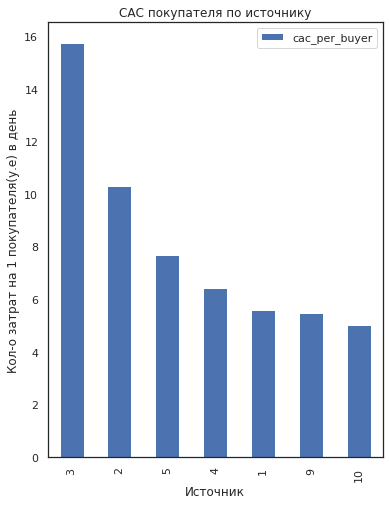

In [171]:
cac_per_buyer.sort_values(by = 'cac_per_buyer', ascending = False).plot(kind = 'bar', figsize = (6,8))
plt.title('CAC покупателя по источнику')
plt.xlabel("Источник")
plt.ylabel("Кол-о затрат на 1 покупателя(у.е) в день")
plt.show()

1. Мы видим, что наибольшая стоимость привлечения в день на одного покупателя приходится на третий источник(почти 16 у.е.).
2. Второе место занимает с большим отрывом второй источник(10 у.е).
3. Самым дешёвыми источниками привлечения являются десятый и девятый каналы привлечения (соответственно 5.3 и 4.3 у.е).
4. Но сама по себе эта величина говорит нам недостаточно, т.к нам важно знать какой доход мы имеем с каждого покупателя который пришел с определенного источника. Если он тратит больше, чем стоит его привлечение, то дорогое привлечение окупается.

## Насколько окупились расходы? (ROI)

In [172]:
cohorts_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,"9,557.49",0,4.72
1,2017-06-01,2023,2017-07-01,981.82,1,0.49
2,2017-06-01,2023,2017-08-01,885.34,2,0.44
3,2017-06-01,2023,2017-09-01,"1,931.30",3,0.95
4,2017-06-01,2023,2017-10-01,"2,068.58",4,1.02


In [173]:
costs_per_month = costs.groupby('month').agg({'costs':'sum'}).reset_index()

In [174]:
costs_per_month.columns = ['month','costs_month']

In [175]:
report_updated = cohorts_new.merge(costs_per_month, left_on = 'first_order_month', right_on = 'month')

In [176]:
report_updated['cac'] = report_updated['costs_month'] / report_updated['n_buyers']

In [177]:
report_updated['romi'] = report_updated['ltv'] / report_updated['cac']

In [178]:
output = report_updated.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output.index = output.index.strftime('%Y-%m')

In [179]:
output.cumsum(axis=1).round(2).fillna("")

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,,
2017-09,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,,,
2017-10,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,,,,
2017-11,0.55,0.60,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12,0.54,0.57,0.68,0.80,0.84,0.87,,,,,,
2018-01,0.42,0.45,0.48,0.49,0.50,,,,,,,
2018-02,0.46,0.49,0.50,0.51,,,,,,,,
2018-03,0.56,0.60,0.63,,,,,,,,,


In [180]:
output.cumsum(axis=1).mean(axis=0)

age
0    0.54
1    0.58
2    0.63
3    0.72
4    0.78
5    0.86
6    0.90
7    0.97
8    1.05
9    0.96
10   1.09
11   1.33
dtype: float64

1. Как можем заметить июньская когорта окупилась на шестом месяце lifetime, сентябрьская на третьем. 
2. Остальные когорты так и не окупились, что говорит о не самой успешной маркетинговой стратегии.
3. При подсчёте "средней когорты", мы можем сказать, что в среднем когорты начинают окупаться на восьмом месяце жизни lifetime

### Выводы по маркетингу

1. СКОЛЬКО ВСЕГО ПОТРАТИЛИ?. В абсолютных показателях больше всего потратили на рекламный источник №3. За ним идут чётвертый, пятый и второй. Меньше всего тратят на 10 и 9 источники.
2. ТРАТЫ ВО ВРЕМЕНИ. Больше всего по времени тратили на маркетинг с сентября по февраль.
3. СТОИМОСТЬ ПРИВЛЕЧЕНИЯ ОДНОГО ЮЗЕРА ИЗ КАЖДОГО ИСТОЧНИКА  

A) Мы видим, что наибольшая стоимость привлечения в день на одного покупателя приходится на третий источник - 15.88 у.е. 
B) Второе место занимает с большим отрывом второй источник 10 у.е.
C) Самым дешёвыми источниками привлечения являются девятый и десятый каналы привлечения (4.3  и 5.3 у.е. соответственно).

4. НА СКОЛЬКО ОКУПИЛИСЬ РАСХОДЫ?(ROMI).

A) Окупились растраты только на июньскую и сентябрьские когорты.
B) Как можем заметить июньская когорта окупилась на шестом месяце lifetime, сентябрьская на третьем. 
C) Остальные когорты так и не окупились, что говорит о не самой успешной маркетинговой стратегии.
5. В среднем когорты начинают окупаться начиная с восьмого месяца жизни 

## Как отличаются метрики по устройствам и по рекламным источникам

Для объединения таблицы с месячными тратами на источник и первыми покупателями с заказами создадим "месячные" столбцы

In [181]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

In [182]:
orders_groupped = orders.groupby('uid')['order_date'].min().reset_index()

In [183]:
orders_groupped.columns = ['uid','first_order_date']

In [184]:
orders = orders.merge(orders_groupped, on = 'uid')

In [185]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [186]:
# объединим таблицу с источником и первой сессией с таблицей первой сессии
source_tb = pd.merge(orders,visits_source, on = 'uid')

In [187]:
source_tb.head(2)

,order_date,revenue,uid,order_month,first_order_date,first_order_month,first_session_date,source_id,device,first_vis_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,1,desktop,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2,desktop,2017-06-01


In [188]:
# теперь объединим таблицу с затратами и источником с таблицей первой сессии/покупки 
monthly_tb = pd.merge(source_tb, monthly_costs, left_on =['source_id','first_order_month'],\
                      right_on = ['source_id','month_costs'])

In [189]:
monthly_tb.sample(5)

,order_date,revenue,uid,order_month,first_order_date,first_order_month,first_session_date,source_id,device,first_vis_month,month_costs,costs
35871,2018-02-09 21:24:00,1.05,1610294640690261111,2018-02-01,2018-02-09 21:24:00,2018-02-01,2018-01-30,3,desktop,2018-01-01,2018-02-01,"14,228.56"
29056,2017-12-04 20:56:00,73.33,2150836476152413203,2017-12-01,2017-12-04 20:56:00,2017-12-01,2017-12-04,2,desktop,2017-12-01,2017-12-01,"4,897.80"
47294,2018-05-08 13:49:00,6.29,3740045407002823771,2018-05-01,2018-05-08 13:49:00,2018-05-01,2018-05-08,4,desktop,2018-05-01,2018-05-01,"4,214.21"
36525,2018-02-25 20:08:00,3.50,14488879637099984141,2018-02-01,2018-02-25 20:08:00,2018-02-01,2018-02-25,3,desktop,2018-02-01,2018-02-01,"14,228.56"
13266,2017-09-23 11:40:00,5.87,6319457250986542662,2017-09-01,2017-09-23 11:40:00,2017-09-01,2017-09-22,9,desktop,2017-09-01,2017-09-01,415.62


In [190]:
coh_sizes = monthly_tb.groupby(['source_id','first_order_month']).agg({'uid':'nunique'}).reset_index()

In [191]:
coh_sizes.columns = ['source_id','first_order_month','n_buyers_month']

In [192]:
coh_sizes_device = monthly_tb.groupby(['device','first_order_month']).agg({'uid':'nunique'}).reset_index()

In [193]:
coh_sizes_device.columns  = ['device','first_order_month','n_buyers_month']

In [194]:
# выделим когорты для ltv по источникам
cohort = monthly_tb.groupby(['first_order_month','order_month','source_id']).agg({'revenue':'sum'}).reset_index()

In [195]:
# выделим когорты для cac по источникам
cohort_cac = monthly_tb.groupby(['first_order_month','order_month','source_id']).agg({'costs':'mean'}).reset_index()

In [196]:
# выделим когорты для ltv по устройствам
cohort_device = monthly_tb.groupby(['first_order_month','order_month','device']).agg({'revenue':'sum'}).reset_index()

In [197]:
# # выделим когорты для cac по устройствам
cohort_cac_device = monthly_tb.groupby(['first_order_month','order_month','device']).agg({'costs':'mean'}).reset_index()

In [198]:
# создадим табличку для анализа ltv по источникам
report_tb = pd.merge(coh_sizes, cohort, left_on = ['first_order_month','source_id'], \
                     right_on =['first_order_month','source_id'])

In [199]:
report_tb['age'] = (report_tb['order_month'] -report_tb['first_order_month']) / np.timedelta64(1,'M')

In [200]:
report_tb['age'] = report_tb['age'].round().astype('int')

In [201]:
report_tb['ltv'] = report_tb['revenue'] / report_tb['n_buyers_month']

In [202]:
# табличка для cac по источникам
report_cac = pd.merge(coh_sizes, cohort_cac, left_on = ['first_order_month','source_id'], \
                     right_on =['first_order_month','source_id'])

In [203]:
report_cac['age'] = (report_cac['order_month'] -report_cac['first_order_month']) / np.timedelta64(1,'M')

In [204]:
report_cac['age'] = report_cac['age'].round().astype('int')

In [205]:
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers_month']

In [206]:
# создадим табличку для анализа ltv по девайсам
report_device = pd.merge(coh_sizes_device, cohort_device, left_on = ['first_order_month','device'], \
                     right_on =['first_order_month','device'])

In [207]:
report_device['age'] = (report_device['order_month'] -report_device['first_order_month']) / np.timedelta64(1,'M')

In [208]:
report_device['age'] = report_device['age'].round().astype('int')

In [209]:
report_device['ltv'] = report_device['revenue'] / report_device['n_buyers_month']

In [210]:
# табличка для cac по источникам
report_cac_device = pd.merge(coh_sizes_device, cohort_cac_device, left_on = ['first_order_month','device'], \
                     right_on =['first_order_month','device'])

In [211]:
report_cac_device['age'] = (report_cac_device['order_month'] -report_cac_device['first_order_month']) / np.timedelta64(1,'M')

In [212]:
report_cac_device['age'] = report_cac_device['age'].round().astype('int')

In [213]:
report_cac_device['cac'] = report_cac_device['costs'] / report_cac_device['n_buyers_month']

In [214]:
# сводная таблица для ltv
pivot_ltv = report_tb.pivot_table(
        index = ['source_id','first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1)

In [215]:
# сводная таблица для трат по источникам
pivot_cac = report_cac.pivot_table(
        index = ['source_id','first_order_month'],
        columns = 'age',
        values = 'cac',
        aggfunc = 'mean')

In [216]:
# сводная таблица для ltv по устройствам
pivot_ltv_device = report_device.pivot_table(
        index = ['device','first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1)

In [217]:
# сводная таблица cac по устройствам
pivot_cac_device = report_cac_device.pivot_table(
        index = ['device','first_order_month'],
        columns = 'age',
        values = 'cac',
        aggfunc = 'mean')

In [218]:
# траты на одного пользователя по источникам
report_cac.groupby('source_id').agg({'cac':'mean'}).sort_values(by = 'cac', ascending = False)

,cac
source_id,
3,16.22
2,10.09
5,7.39
4,7.20
1,5.64
10,5.51
9,3.77


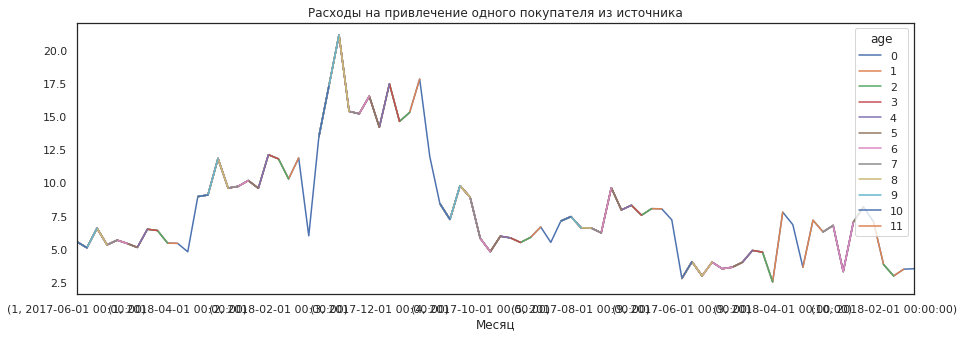

In [219]:
# построим график изменения трат по источникам в динамике 

pivot_cac.plot(figsize = (15,5), title = 'Расходы на привлечение одного покупателя из источника')
plt.xlabel("Месяц")
plt.show()

- Можем заметить на графике достаточно серьезный отрыв имеет первый источник который стабильно держался на первых позициях
- Второй источник только к концу сдал свои позиции по количестве использованных ресурсов
- В конце изучаемого периода расходы на наиболее дорогие третий и второй источник значительно сокращаются с апреля по май

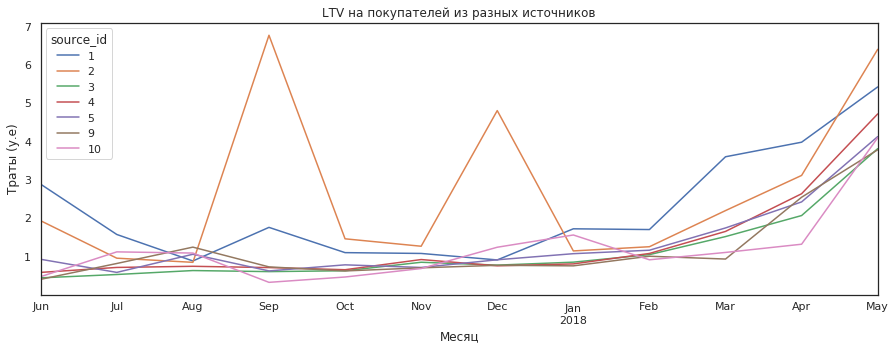

In [220]:
pivot_ltv_graph = report_tb.pivot_table(index = 'first_order_month', columns = 'source_id', values  = 'ltv')
pivot_ltv_graph.plot(figsize = (15,5), title = 'LTV на покупателей из разных источников')
plt.xlabel("Месяц")
plt.ylabel('Траты (у.е)')
plt.show()

- ltv пользователей из второго источника наиболее нестабильен и испытывал наибольшие колебания колебания в течении времени
- ltv пользователей из первого источника начало стабильно расти в декабре и продолжила до конца периода замера
- также благодаря росту на третье место вырвалось ltv пользователей пришедших по третьему источнику
- в целом наблюдаем рост ltv по пользователей из всех каналов ближе к концу изучаемого периода, что свидетельствует о положительной динамике измеряемого признака

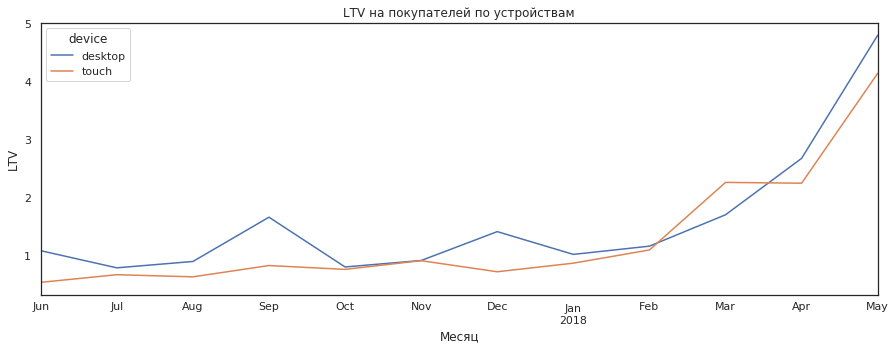

In [221]:
pivot_cac_device_graph =  report_device.pivot_table(index = 'first_order_month', columns = 'device', values  = 'ltv')
pivot_cac_device_graph.plot(figsize = (15,5), title = 'LTV на покупателей по устройствам')
plt.xlabel('Месяц')
plt.ylabel('LTV')
plt.show()

- Пользователи стационарных компьютеров почти весь периол приносили больший ltv, начиная с начала исследуемого периода и до конца. Только с февраля по март пользователи мобильных девайсов имели более высокий ltv.


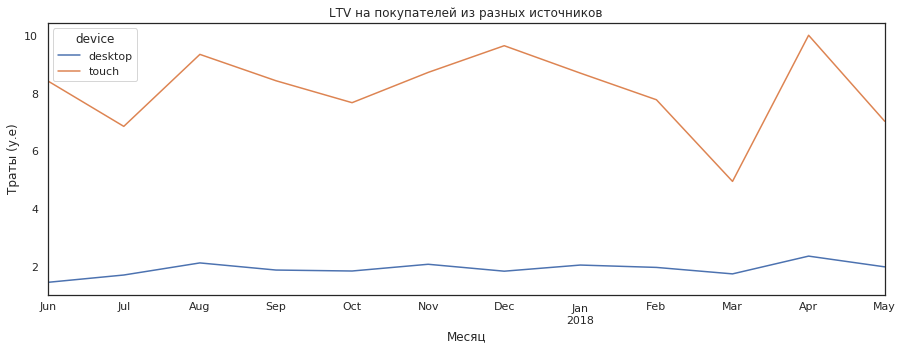

In [222]:
pivot_cac_device_graph = report_cac_device.pivot_table(index = 'first_order_month', columns = 'device', values  = 'cac')
pivot_cac_device_graph.plot(figsize = (15,5), title = 'LTV на покупателей из разных источников')
plt.xlabel("Месяц")
plt.ylabel('Траты (у.е)')
plt.show()

- Стоимость привлечения пользователей мобильных устройств значительно превышает "стационарных" пользоватлей на протяжении всего исследуемого периода.
- В то же время ltv от пользователей со стационарных устройств чуть превышает "мобильных" пользователей. Это говорит о том, что маркетинговому отделу следует больше средств вкладывать в маркетинг для пользователей pc, которые потом приносять больше ltv.

Посчитаем по отдельности средний ltv юзера за 6 месяцев существования сервиса отдельно по каждому источнику привлечения 

In [223]:
report_1 = report_tb[report_tb['source_id'] == 1]

In [224]:
report_2 = report_tb[report_tb['source_id'] == 2]

In [225]:
report_3 = report_tb[report_tb['source_id'] == 3]

In [226]:
report_4 = report_tb[report_tb['source_id'] == 4]

In [227]:
report_5 = report_tb[report_tb['source_id'] == 5]

In [228]:
report_9 = report_tb[report_tb['source_id'] == 9]

In [229]:
report_10 = report_tb[report_tb['source_id'] == 10]

Теперь построим сводные таблицы для каждого источника и вытянем средний ltv юзера каждой когорты после 6 месяцев использования

In [230]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_1 = report_1.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [231]:
# сводная табличка с ltv от пришедших по второму источнику
pivot_2 = report_2.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [232]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_3 = report_3.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [233]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_4 = report_4.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [234]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_5 = report_5.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [235]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_9 = report_9.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [236]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_10 = report_10.pivot_table(
        index = ['source_id' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [237]:
pivot_1[5]= pd.to_numeric(pivot_1[5]) 

In [238]:
pivot_2[5]= pd.to_numeric(pivot_2[5]) 

In [239]:
pivot_3[5]= pd.to_numeric(pivot_3[5]) 

In [240]:
pivot_4[5]= pd.to_numeric(pivot_4[5]) 

In [241]:
pivot_5[5]= pd.to_numeric(pivot_5[5]) 

In [242]:
pivot_9[5]= pd.to_numeric(pivot_9[5]) 

In [243]:
pivot_10[5]= pd.to_numeric(pivot_10[5]) 

In [244]:
print('1. В среднем LTV пользователей, пришедних из первого источника, за полгода равен:', pivot_1[5].mean(axis=0).round(2))
print()
print('2. В среднем LTV пользователей, пришедних из второго источника, за полгода равен:', pivot_2[5].mean(axis=0).round(2))
print()
print('3. В среднем LTV пользователей, пришедних из третьего источника, за полгода равен:', pivot_3[5].mean(axis=0).round(2))
print()
print('4. В среднем LTV пользователей, пришедних из четвёртого источника, за полгода равен:', pivot_4[5].mean(axis=0).round(2))
print()
print('5. В среднем LTV пользователей, пришедних из пятого источника, за полгода равен:', pivot_5[5].mean(axis=0).round(2))
print()
print('9. В среднем LTV пользователей, пришедних из девятого источника, за полгода равен:', pivot_9[5].mean(axis=0).round(2))
print()
print('10. В среднем LTV пользователей, пришедних из десятого источника, за полгода равен:', pivot_10[5].mean(axis=0).round(2))



1. В среднем LTV пользователей, пришедних из первого источника, за полгода равен: 10.67

2. В среднем LTV пользователей, пришедних из второго источника, за полгода равен: 19.59

3. В среднем LTV пользователей, пришедних из третьего источника, за полгода равен: 5.33

4. В среднем LTV пользователей, пришедних из четвёртого источника, за полгода равен: 5.89

5. В среднем LTV пользователей, пришедних из пятого источника, за полгода равен: 6.58

9. В среднем LTV пользователей, пришедних из девятого источника, за полгода равен: 5.66

10. В среднем LTV пользователей, пришедних из десятого источника, за полгода равен: 3.73


In [245]:
report_cac.groupby('source_id').agg({'cac':'mean'}).reset_index().sort_values(by = 'source_id')

,source_id,cac
0,1,5.64
1,2,10.09
2,3,16.22
3,4,7.20
4,5,7.39
5,9,3.77
6,10,5.51


In [246]:
print ("Romi первого источника:",10.67 / 5.64)
print ("Romi второго источника:",19.59 / 10.09)
print ("Romi третьего источника:",5.33 / 16.22)
print ("Romi четвёртого источника:",5.89 / 16.22)
print ("Romi пятого источника:",6.58 / 7.39)
print ("Romi девятого источника:",5.66 / 3.77)
print ("Romi десятого источника:",3.73 / 5.51)


Romi первого источника: 1.8918439716312059
Romi второго источника: 1.9415262636273538
Romi третьего источника: 0.32860665844636255
Romi четвёртого источника: 0.3631319358816276
Romi пятого источника: 0.8903924221921516
Romi девятого источника: 1.5013262599469497
Romi десятого источника: 0.676950998185118


- Как можем заметить наиболее прибыльными являются второй и первый источники с показателями 1.94 и 1.89 соответственно
- Девятый источник с показателем 1.5 также является очень прибыльным
- Наименее прибыльными источниками с возвратностью чуть больше 30% вложений являются третий (0.32) и четвёртый (0.36) источники

In [247]:
report_desktop = report_device[report_device['device'] == 'desktop']

In [248]:
report_mobile = report_device[report_device['device'] == 'touch']

In [249]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_desktop = report_desktop.pivot_table(
        index = ['device' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [250]:
pivot_desktop

age                         0    1    2     3     4     5     6     7     8   \
device  first_order_month                                                      
desktop 2017-06-01        4.88 5.38 5.88  7.02  8.18  9.04 10.17 10.87 11.52   
        2017-07-01        5.95 6.32 7.10  7.51  7.69  7.85  7.99  8.15  8.33   
        2017-08-01        5.29 5.84 6.38  6.84  7.43  7.72  7.95  8.42  8.76   
        2017-09-01        5.87 6.86 7.35 12.30 12.79 13.59 14.43 14.73 14.95   
        2017-10-01        5.07 5.54 5.75  5.92  6.09  6.21  6.31  6.42         
        2017-11-01        4.97 5.44 5.66  6.04  6.20  6.26  6.40               
        2017-12-01        4.93 5.22 6.36  7.68  8.06  8.47                     
        2018-01-01        4.16 4.50 4.86  5.03  5.10                           
        2018-02-01        4.18 4.47 4.56  4.65                                 
        2018-03-01        4.60 4.79 5.11                                       
        2018-04-01        4.72 5.35                                            
        2018-05-01        4.80                                                 

age                          9     10    11  
device  first_order_month                    
desktop 2017-06-01        12.19 12.86 13.00  
        2017-07-01         8.50  8.67        
        2017-08-01         8.97              
        2017-09-01                           
        2017-10-01                           
        2017-11-01                           
        2017-12-01                           
        2018-01-01                           
        2018-02-01                           
        2018-03-01                           
        2018-04-01                           
        2018-05-01

In [251]:
# сводная табличка с ltv от пришедших по первому источнику
pivot_mobile = report_mobile.pivot_table(
        index = ['device' ,'first_order_month'],
        columns = 'age',
        values = 'ltv',
        aggfunc = 'mean').cumsum(axis =1).fillna("")

In [252]:
pivot_mobile

age                        0    1    2    3    4    5    6    7    8    9   \
device first_order_month                                                     
touch  2017-06-01        3.99 4.37 4.51 4.58 4.95 5.10 5.14 5.15 5.27 5.54   
       2017-07-01        6.22 6.44 6.48 6.68 6.83 6.97 7.03 7.11 7.20 7.26   
       2017-08-01        5.22 5.38 5.49 5.57 5.66 5.91 6.06 6.17 6.24 6.33   
       2017-09-01        4.73 6.36 7.02 7.15 7.17 7.23 7.37 7.39 7.44        
       2017-10-01        4.71 5.53 5.64 5.73 5.81 5.93 5.96 6.09             
       2017-11-01        5.97 6.07 6.18 6.25 6.33 6.35 6.38                  
       2017-12-01        3.96 4.10 4.17 4.26 4.29 4.32                       
       2018-01-01        4.04 4.15 4.25 4.31 4.34                            
       2018-02-01        4.06 4.33 4.36 4.38                                 
       2018-03-01        5.77 6.49 6.78                                      
       2018-04-01        4.38 4.49                                           
       2018-05-01        4.14                                                

age                        10   11  
device first_order_month            
touch  2017-06-01        5.64 6.45  
       2017-07-01        7.36       
       2017-08-01                   
       2017-09-01                   
       2017-10-01                   
       2017-11-01                   
       2017-12-01                   
       2018-01-01                   
       2018-02-01                   
       2018-03-01                   
       2018-04-01                   
       2018-05-01

In [253]:
pivot_desktop[5] = pd.to_numeric(pivot_desktop[5])

In [254]:
pivot_mobile[5] = pd.to_numeric(pivot_mobile[5])

In [255]:
print('1. В среднем LTV пользователей, пришедних с pc, за полгода равен:', \
      pivot_desktop[5].mean(axis=0).round(2))
print('1. В среднем LTV пользователей, пришедних с мобильного устройства, за полгода равен:', \
      pivot_mobile[5].mean(axis=0).round(2))

1. В среднем LTV пользователей, пришедних с pc, за полгода равен: 8.45
1. В среднем LTV пользователей, пришедних с мобильного устройства, за полгода равен: 5.97


In [256]:
report_cac_device.groupby('device').agg({'cac':'mean'}).reset_index().sort_values(by = 'cac')

,device,cac
0,desktop,1.87
1,touch,8.24


- LTV за полгода пользователей со стационарных компьютеров на 40% выше, чем у пользователей с мобильных устройств.
- В то же время стоимость привлечения на мобильных устройствах в 4 раза выше. 
- Поэтому рекомендуем больше вкладывать в привлечение пользователей со стационарных устройств, а не тех, что используют мобильные дейвайсы

## <a id="step6">6. Общие выводы.</a>

1. Профиль активности пользователя:
 - dau = 907
 - wau = 5,716
 - mau= 23,228

 - sticky wau = 15
 - sticky mau = 3

2.	В среднем юзер проводит в приложении одну сессию в день
3.	CРЕДНЯЯ ДЛИТЕЛЬНОСТЬ СЕССИИ – 60 секунд (1 минута)
4.	RETENTION RATE - в первый месяц составляет примерно 5-8%. К 7-8 месяцу жизненного цикла опускается до 2%. Это низкий показатель, следует поработать над удержанием пользователей или подумать о другой целевой аудитории.

5.	- Наибольшее количество пользователей (около 20 тысяч) покупает на второй день использования сервиса, либо в самые первые дни(еще чуть меньше 10тысяч). 
    - Данные сдвинуты в сторону малых значений.В силу того, что многие делают покупку гораздо позднее того момента, как они начала пользоваться сервисом, в среднем проходит около 17 дней дней прежде чем пользователь делает первую покупку. Срок не такой уж долгий, хотя можно поработать над его улучшением.

6. КОЛИЧЕСТВО ПОКУПОК ЗА ПЕРИОД. 

 - В день в среднем: 139 покупок
 - В неделю в среденем: 951 покупка
 - В месяц в среднем 3878 покупок


7. СРЕДНИЙ ЧЕК - 4.99. 
   - Наиболее прибыльными являются когорты июня,сентября и декабря 2017 года. 
   - Июльские, сентябрьские и декабрьские когорты 2017 имели самые высокие показатели ltv.


8. СТОИМОСТЬ ПРИВЛЕЧЕНИЯ. 

- СКОЛЬКО ВСЕГО ПОТРАТИЛИ?. 
   - В абсолютных показателях больше всего потратили на рекламный источник №3 (140 000). За ним идут чётвертый(около 60 000), пятый и второй. Меньше всего тратят на 10 и 9 источники (около 6 000).
- ТРАТЫ ВО ВРЕМЕНИ. 
   - Больше всего по времени тратили на маркетинг с сентября по февраль.

10. СТОИМОСТЬ ПРИВЛЕЧЕНИЯ ОДНОГО ЮЗЕРА ИЗ КАЖДОГО ИСТОЧНИКА  

    -  Мы видим, что наибольшая стоимость привлечения на одного покупателя приходится на третий источник - 15.88 у.е. 
    -  Второе место занимает с большим отрывом второй источник 10 у.е.
    -  Самым дешёвыми источниками привлечения являются девятый и десятый каналы привлечения (4.3  и 5.3 у.е. соответственно).

11. НА СКОЛЬКО ОКУПИЛИСЬ РАСХОДЫ?(ROMI).

   - Как можем заметить июньская когорта окупилась на шестом месяце lifetime, сентябрьская на третьем.
   - Остальные когорты так и не окупились, что говорит о не самой успешной маркетинговой стратегии.
   - При подсчёте "средней когорты", мы можем сказать, что в среднем когорты начинают окупаться на восьмом месяце жизни lifetime
     Сопоставляя ltv и cac разных источников привлечения и устройст можем сделать определенные выводы:
     -  Как можем заметить наиболее прибыльными являются второй и первый источники с показателями 1.94 и 1.89 соответственно. Девятый источник с показателем 1.5 также является очень прибыльным.
     -  Наименее прибыльными источниками с возвратностью чуть больше 30% вложений являются третий (0.32) и четвёртый (0.36) источники
      - LTV за полгода пользователей со стационарных компьютеров на 40% выше, чем у пользователей с мобильных устройств.
      - В то же время стоимость привлечения на мобильных устройствах в 4 раза выше.
      - Поэтому рекомендуем больше вкладывать в привлечение пользователей со стационарных устройств, а не тех, что используют мобильные дейвайсы

12. Советы маркетологам:
    - Инвестировать во второй, первый и девятый источники.
    - Сократить или пересмотреть вложения в третий и четвертый источники
    - Следует больше инвестировать в привлечение пользователей на стационарных компьютерах, а не на мобильных устройствах.
